In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import data
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor

X, Y = data.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# linear model

In [4]:
X_patches, Y_centers = data.extract_patch_features(X, Y)

In [5]:
X_patches.shape

(109174, 9, 9, 300)

In [6]:
Y_centers.shape

(109174,)

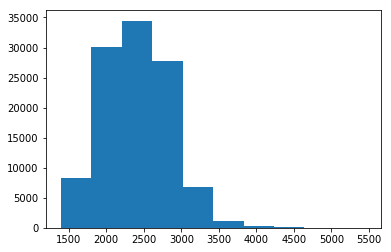

In [7]:
plt.hist(Y_centers)
plt.show()

In [51]:
n = 10000
X_flat = X_patches[:n].reshape(n, -1)
Y_flat = Y_centers[:n]

In [ ]:
# m = LinearRegression()
m = RidgeCV(store_cv_values=True)
m_fit = m.fit(X_flat, Y_flat)

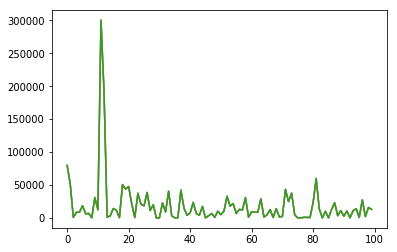

In [9]:
plt.plot(m_fit.cv_values_)

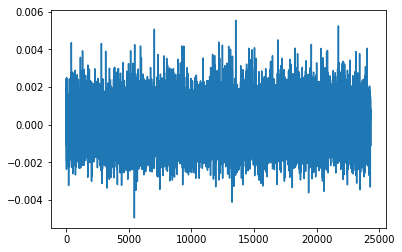

In [46]:
plt.plot(m.coef_)

In [45]:
m.coef_.shape

(24300,)

In [46]:
print('score', m.score(X_flat, Y_flat))

score 0.9999999999999848


# multi-linear model

In [ ]:
from models import MaxLinear

net = NeuralNetRegressor(
    MaxLinear(),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-6,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
)

X = X_flat.astype(np.float32)
Y = Y_flat.reshape(-1, 1).astype(np.float32)
# X, y = make_classification(1000, 20, n_informative=10, random_state=0)
# X = X.astype(np.float32)
# y = y.astype(np.int64)

net.fit(X, Y)


Text(0, 0.5, 'Yhat')

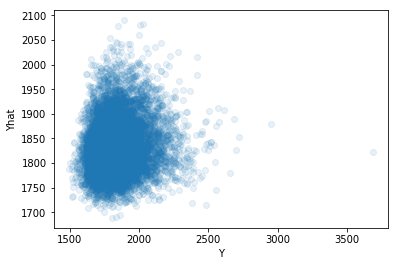

In [68]:
yhat = net.predict(X)
plt.plot(Y, yhat, 'o', alpha=0.1)
# sns.lmplot(Y.astype(np.float32), yhat.astype(np.float32))
plt.xlabel('Y')
plt.ylabel('Yhat')

In [71]:
n = 1000
X_flat = X_patches[:n] #.reshape(n, -1)
Y_flat = Y_centers[:n]

In [72]:
X_patches.shape

(109174, 9, 9, 300)

In [ ]:
class MaxTemporalConv(nn.Module):
    '''Takes input which is batch_size x H_patch x W_patch x time and learns temporal convolution
    '''
    def __init__(self, input_dim=24300, num_units=20, nonlin=F.relu):
        super(MaxLinear, self).__init__()

        self.fc1 = nn.Linear(input_dim, num_units)

    def forward(self, X, **kwargs):
#         print('in shape', X.shape, X.dtype)
        X = self.fc1(X) #.max(dim=-1)
#         print('out shape', X.shape, X.dtype)
        X = torch.max(X, dim=1)[0] # 0 because this returns max, indices
#         print('out2 shape', X.shape, X.dtype)
        return X